<a href="https://colab.research.google.com/github/rae-fahrenholtz/Elon/blob/main/my_elon_df.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pandas_datareader.data as web
from datetime import timedelta

```
my_tweets_df: daily, 0 for days no tweets
my_tsla_df: weekdays, interpolate for weekend data
my_doge_df: start date: 2020-07-30, daily
my_sp_df: weekdays, interpolate for weekend data
my_google_df:
my_crypto_df: start date: 2017-02-28


```

# Load Data

## Twitter Data

### Kaggle Twitter Data

example: 2017 data 

url:
`https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/elon_tweets_2017.csv`

In [520]:
#function to index and clean Elon musk tweet data from github repo 

#year: str, no spaces
#possible years: [2017 - 2021]

def get_yearly_elon_tweets(year):
  
  #define url 
  url_a = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/elon_tweets_'
  url_b = year
  url_c = '.csv'
  url = url_a + url_b + url_c

  #read data
  df = pd.read_csv(url, parse_dates=['date'])
  
  #index with date (no hourly)
  df.index = pd.DatetimeIndex(df['date']).floor('D')
  
  #data cleaning, only tweets in coresponding year
  start_date = year + '0101' 
  end_date = year + '1231' 
  query_str = start_date + ' <= date <= ' + end_date
  df = df.query(query_str)
  return(df)


In [521]:
df_2017 = get_yearly_elon_tweets('2017')
df_2018 = get_yearly_elon_tweets('2018')
df_2019 = get_yearly_elon_tweets('2019')
df_2020 = get_yearly_elon_tweets('2020')
df_2021 = get_yearly_elon_tweets('2021')

In [522]:
tweet_df = pd.concat([df_2017, df_2018, df_2019, df_2020, df_2021], axis=0)

In [523]:
tweet_df.shape

(10218, 39)

In [524]:
#excludes tweet replies
tweet_df = tweet_df[tweet_df['reply_to'] == '[]']

In [525]:
tweet_df.shape

(2585, 39)

In [526]:
#extract column of interest, nlikes
my_tweet_df = pd.concat([tweet_df['nlikes']], names=['nlikes'], axis=1)

In [527]:
#sorts dates from oldest to newest
my_tweet_df = my_tweet_df.sort_index()

In [528]:
my_tweet_df.head()

,nlikes
date,
2017-01-05,14041
2017-01-08,2944
2017-01-08,6092
2017-01-11,1798
2017-01-12,11236


In [529]:
my_tweet_df.tail()

,nlikes
date,
2021-03-18,185857
2021-03-18,90027
2021-03-18,217422
2021-03-19,327982
2021-03-20,370258


In [530]:
my_tweet_df.isnull().sum()

nlikes    0
dtype: int64

In [531]:
#average daily number of likes, fills missing dates with NaN
my_tweet_df = my_tweet_df.resample('D').mean()

In [532]:
my_tweet_df

,nlikes
date,
2017-01-05,14041.000000
2017-01-06,NaN
2017-01-07,NaN
2017-01-08,4518.000000
2017-01-09,NaN
...,...
2021-03-16,65737.000000
2021-03-17,64341.000000
2021-03-18,164435.333333


In [533]:
my_tweet_df = my_tweet_df.fillna(0)

In [534]:
my_tweet_df.isnull().sum()

nlikes    0
dtype: int64

In [535]:
#reindex for all dates in the year 
all_dates = pd.date_range(start='1/1/2017', end='3/20/2021')

In [536]:
#for days with no tweets, fill with zero
my_tweet_df = my_tweet_df.reindex(all_dates, fill_value=0)

In [537]:
my_tweet_df.isnull().sum()

nlikes    0
dtype: int64

In [538]:
my_tweet_df.tail()

,nlikes
2021-03-16,65737.000000
2021-03-17,64341.000000
2021-03-18,164435.333333
2021-03-19,327982.000000
2021-03-20,370258.000000


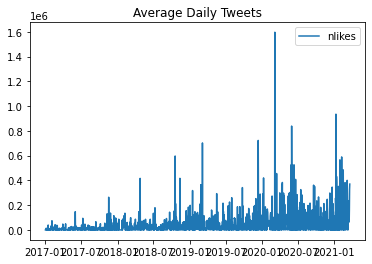

In [539]:
sns.lineplot(data=my_tweet_df)
plt.title('Average Daily Tweets')
plt.show()

In [540]:
my_tweet_df.head()

,nlikes
2017-01-01,0.0
2017-01-02,0.0
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,14041.0


In [541]:
my_tweet_df.tail()

,nlikes
2021-03-16,65737.000000
2021-03-17,64341.000000
2021-03-18,164435.333333
2021-03-19,327982.000000
2021-03-20,370258.000000


In [542]:
my_tweet_df.shape

(1540, 1)

In [543]:
my_tweet_df.isnull().sum()

nlikes    0
dtype: int64

### Twitter API Data

Data in repo: https://www.github.com/rae-fahrenholtz/Elon

In [395]:
import base64
import requests
import pandas as pd
import json

In [418]:
# function to extract number of likes and date of tweet from json data from
# Twitter API

# Data is in repo https://www.github.com/rae-fahrenholtz/Elon

# url: str, link to json data

def my_json_to_df(url):
    master = url
    req = requests.get(master)
    req = req.text                        #json as string
    d = json.loads(req)                   #json as dict
    ntweets = len(d['data'])              #num of tweets
    likes = []                            #initialize lists
    date = []                
    
    for i in range(ntweets):              #extract nlikes and date from dict
        likes.append(d['data'][i]
                     ['public_metrics']['like_count'])
        date.append(d['data'][i]['created_at'][0:10])
    
    date_datetime = pd.to_datetime(date)  #convert to datetime index
    nlikes_s = pd.Series(likes, index=date_datetime, name='nlikes')
    nlikes_df = pd.DataFrame(nlikes_s)                                           
    nlikes_df = nlikes_df.sort_index()    #reorders date from oldest to newest
    
    return(nlikes_df)

In [419]:
url1 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2022-01-31'
url2 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-12-01'
url3 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-09-02'
url4 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-06-25'
url5 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-04-15'
url6 = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/api_tweets_2021-02-25'

In [420]:
api_tweet1_df = my_json_to_df(url1)
api_tweet2_df = my_json_to_df(url2)
api_tweet3_df = my_json_to_df(url3)
api_tweet4_df = my_json_to_df(url4)
api_tweet5_df = my_json_to_df(url5)
api_tweet6_df = my_json_to_df(url6)

In [421]:
api_tweets_df = pd.concat([api_tweet1_df, api_tweet2_df, api_tweet3_df, api_tweet4_df, api_tweet5_df, api_tweet6_df], axis=0)

In [422]:
api_tweets_df.shape

(600, 1)

In [427]:
#sorts dates from oldest to newest
api_tweets_df = api_tweets_df.sort_index()

In [428]:
my_api_tweets = api_tweets_df['03/21/2021':'12/31/2021']

In [429]:
#average daily number of likes 
my_api_tweets = my_api_tweets.resample('D').mean()

In [430]:
#reindex for all dates in the year 
all_dates = pd.date_range(start='3/21/2021', end='12/31/2021')

In [431]:
#for days with no tweets, fill with zero
my_api_tweets = my_api_tweets.reindex(all_dates, fill_value=0)

In [432]:
#fill missing values with 0 
my_api_tweets = my_api_tweets.fillna(0)

In [433]:
my_api_tweets.head()

,nlikes
2021-03-21,0.0
2021-03-22,0.0
2021-03-23,446216.0
2021-03-24,393710.0
2021-03-25,394930.0


In [434]:
my_api_tweets.tail()

,nlikes
2021-12-27,99380.5
2021-12-28,87572.0
2021-12-29,0.0
2021-12-30,347370.5
2021-12-31,0.0


In [435]:
my_api_tweets.isnull().sum()

nlikes    0
dtype: int64

### Combine Kaggle Tweets and API Tweets

In [544]:
my_api_tweets.head()

,nlikes
2021-03-21,0.0
2021-03-22,0.0
2021-03-23,446216.0
2021-03-24,393710.0
2021-03-25,394930.0


In [545]:
my_tweet_df.head()

,nlikes
2017-01-01,0.0
2017-01-02,0.0
2017-01-03,0.0
2017-01-04,0.0
2017-01-05,14041.0


In [546]:
my_tweet_df.tail()

,nlikes
2021-03-16,65737.000000
2021-03-17,64341.000000
2021-03-18,164435.333333
2021-03-19,327982.000000
2021-03-20,370258.000000


In [547]:
my_tweets_df = pd.concat([my_tweet_df, my_api_tweets], axis = 0)

In [548]:
my_tweets_df.isnull().sum()

nlikes    0
dtype: int64

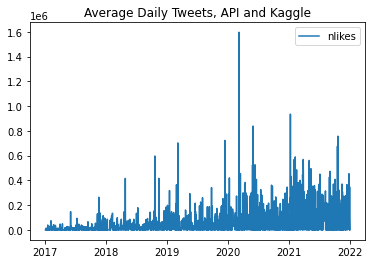

In [549]:
sns.lineplot(data=my_tweets_df)
plt.title('Average Daily Tweets, API and Kaggle')
plt.show()

## TSLA Data

In [95]:
!pip install finnhub-python

In [96]:
import finnhub

In [97]:
finnhub_client = finnhub.Client(api_key="c7h1h52ad3ibsjtt5ug0")

In [98]:
print(datetime.date.fromtimestamp(1483228800))

2017-01-01


In [99]:
print(datetime.date.fromtimestamp(1640908800))

2021-12-31


In [100]:
epoch_start_date = 1483228800
epoch_end_date = 1640908800

In [101]:
#display the high, low, open, and closing prices of a security for a specific 
#period in epoch time (1/1/2017 - 12/31/2021)
tsla_candle_df = pd.DataFrame(finnhub_client.stock_candles(
    'TSLA', 'D', epoch_start_date, epoch_end_date))

In [102]:
#create time column in YYYY-MM-DD format
tsla_candle_df['date'] = pd.to_datetime(tsla_candle_df['t'],unit='s')
tsla_candle_df['day_of_week'] = pd.to_datetime(tsla_candle_df['t'],unit='s').dt.day_name()

In [103]:
tsla_candle_df = tsla_candle_df.set_index('date')

In [104]:
# extract closing column ('c') with same index
my_tsla_df = pd.DataFrame(tsla_candle_df['c'], index=tsla_candle_df.index)
my_tsla_df = my_tsla_df.rename(columns={'c': 'tsla'})

In [105]:
my_tsla_df.head()

,tsla
date,
2017-01-03,43.398
2017-01-04,45.398
2017-01-05,45.350
2017-01-06,45.802
2017-01-09,46.256


In [106]:
#reindex for all dates in the year 
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

In [107]:
#for days with no quotes, fill with missing value, (np.NaN is default)
my_tsla_df = my_tsla_df.reindex(all_dates)

In [108]:
my_tsla_df.head()

,tsla
2017-01-01,NaN
2017-01-02,NaN
2017-01-03,43.398
2017-01-04,45.398
2017-01-05,45.350


In [109]:
#fill missing values with interpolate
#limit_direction = 'both' estimates both forward and backward projections

my_tsla_df['tsla'] = my_tsla_df['tsla'].fillna(my_tsla_df['tsla'].interpolate(limit_direction='both'))

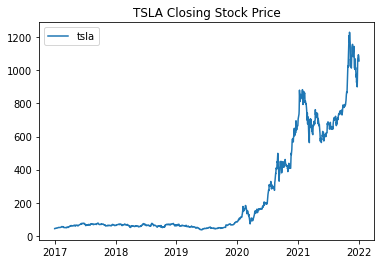

In [110]:
sns.lineplot(data=my_tsla_df)
plt.title('TSLA Closing Stock Price')
plt.show()

In [111]:
my_tsla_df.head()

,tsla
2017-01-01,43.398
2017-01-02,43.398
2017-01-03,43.398
2017-01-04,45.398
2017-01-05,45.350


In [112]:
my_tsla_df.shape

(1826, 1)

## DOGE Data

In [644]:
cryptos = pd.DataFrame(finnhub_client.crypto_symbols('BINANCE'))

In [645]:
print(datetime.date.fromtimestamp(1483228800))

2017-01-01


In [646]:
print(datetime.date.fromtimestamp(1640908800))

2021-12-31


In [647]:
epoch_start_date = 1483228800
epoch_end_date = 1640908800

In [648]:
doge_candle_df = pd.DataFrame(finnhub_client.crypto_candles('BINANCE:DOGEBUSD', 
                                                            'D', 
                                                            epoch_start_date, 
                                                            epoch_end_date))

In [649]:
#create time column in YYYY-MM-DD format
doge_candle_df['date'] = pd.to_datetime(doge_candle_df['t'], unit='s')
doge_candle_df['day_of_week'] = pd.to_datetime(doge_candle_df['t'],unit='s').dt.day_name()

In [650]:
print("Only {} days of data for DOGE".format(len(doge_candle_df)))

Only 500 days of data for DOGE


In [652]:
doge_candle_df.tail(20)

,c,h,l,o,s,t,v,date,day_of_week
480,0.2196,0.2273,0.2166,0.2258,ok,1637539200,70924444.0,2021-11-22,Monday
481,0.2267,0.2369,0.2134,0.2196,ok,1637625600,196199289.0,2021-11-23,Tuesday
482,0.2170,0.2305,0.2107,0.2267,ok,1637712000,120944482.0,2021-11-24,Wednesday
483,0.2210,0.2290,0.2140,0.2170,ok,1637798400,123106956.0,2021-11-25,Thursday
484,0.2017,0.2218,0.1863,0.2211,ok,1637884800,259643559.4,2021-11-26,Friday
485,0.2052,0.2094,0.2007,0.2017,ok,1637971200,93468774.0,2021-11-27,Saturday
486,0.2074,0.2076,0.1910,0.2050,ok,1638057600,98784321.0,2021-11-28,Sunday
487,0.2152,0.2254,0.2026,0.2074,ok,1638144000,206163643.0,2021-11-29,Monday
488,0.2148,0.2277,0.2125,0.2152,ok,1638230400,297806801.0,2021-11-30,Tuesday
489,0.2096,0.2189,0.2060,0.2148,ok,1638316800,89242098.0,2021-12-01,Wednesday


In [232]:
doge_candle_df = doge_candle_df.set_index('date')

In [233]:
doge_candle_df.head()

,c,h,l,o,s,t,v,day_of_week
date,,,,,,,,
2020-07-30,0.003232,0.003902,0.003156,0.003158,ok,1596067200,3525952.0,Thursday
2020-07-31,0.003222,0.003238,0.003190,0.003218,ok,1596153600,3263112.0,Friday
2020-08-01,0.003713,0.003877,0.003234,0.003234,ok,1596240000,51932054.0,Saturday
2020-08-02,0.003346,0.003737,0.003068,0.003718,ok,1596326400,23081112.0,Sunday
2020-08-03,0.003386,0.003450,0.003298,0.003327,ok,1596412800,5931436.0,Monday


In [234]:
# extract closing column ('c') with same index
my_doge_df = pd.DataFrame(doge_candle_df['c'], index=doge_candle_df.index)
my_doge_df = my_doge_df.rename(columns={'c':'doge'})

In [236]:
# no missing values, data is for all days of the week
my_doge_df['doge'].isnull().sum() 

0

In [237]:
print("The first day of DOGE data is {}.".format(my_doge_df.index[0]))

The first day of DOGE data is 2020-07-30 00:00:00.


In [238]:
#reindex for all dates, same format as other df
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

In [240]:
#for days with no quotes, fill with missing value, (np.NaN is default)
my_doge_df = my_doge_df.reindex(all_dates)

In [245]:
my_doge_df.index = pd.to_datetime(my_doge_df.index, format='%Y%m%d')

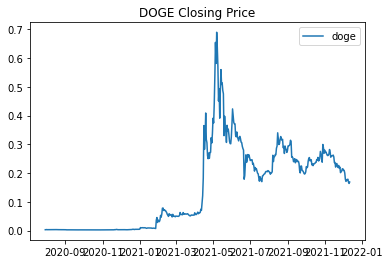

In [247]:
sns.lineplot(data=my_doge_df)
plt.title('DOGE Closing Price')
plt.show()

In [249]:
my_doge_df.head()

,doge
2017-01-01,NaN
2017-01-02,NaN
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN


In [131]:
my_doge_df.shape

(1826, 1)

## S&P500 Index Data

In [132]:
start_date = datetime.datetime(2017, 1, 1)
end_date = datetime.datetime(2021, 12, 31)

In [133]:
my_sp_df = web.DataReader(['sp500'], 'fred', start_date, end_date)

In [134]:
#rename index 
my_sp_df.index = my_sp_df.index.rename('date')

In [135]:
my_sp_df.head()

,sp500
date,
2017-01-02,NaN
2017-01-03,2257.83
2017-01-04,2270.75
2017-01-05,2269.00
2017-01-06,2276.98


In [136]:
#reindex for all dates in the year 
all_dates = pd.date_range(start='1/1/2017', end='12/31/2021')

In [137]:
#for days with no quotes, fill with missing value, (np.NaN is default)
my_sp_df = my_sp_df.reindex(all_dates)

In [138]:
my_sp_df.isnull().sum() / my_sp_df.isnull().count()

sp500    0.310515
dtype: float64

In [139]:
#fill missing values with interpolate
#limit_direction = 'both' estimates both forward and backward projections

my_sp_df['sp500'] = my_sp_df['sp500'].fillna(my_sp_df['sp500'].interpolate(limit_direction='both'))

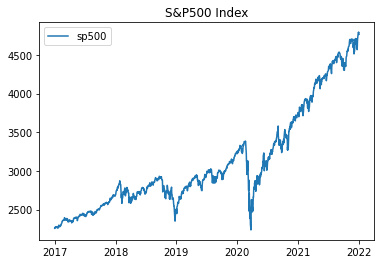

In [140]:
sns.lineplot(data=my_sp_df)
plt.title('S&P500 Index')
plt.show()

In [141]:
my_sp_df.head()

,sp500
2017-01-01,2257.83
2017-01-02,2257.83
2017-01-03,2257.83
2017-01-04,2270.75
2017-01-05,2269.00


In [142]:
my_sp_df.shape

(1826, 1)

## Google Data

pytrends (google trends api)
-relative popularity (not absolute)

In [143]:
!pip install pytrends

In [144]:
from pytrends.request import TrendReq

In [145]:
#build model
pytrend = TrendReq()

In [146]:
#provide your search terms
kw_list = ['Elon Musk']
pytrend.build_payload(kw_list=kw_list)

In [147]:
#historical interest
historicaldf = pytrend.get_historical_interest(kw_list, 
                                                year_start=2017, month_start=1, day_start=1, hour_start=0,
                                                year_end=2021, month_end=12, day_end=31, hour_end=0, 
                                                cat=0, geo='', gprop='', sleep=0)

In [611]:
historicaldf.keys()

Index(['Elon Musk', 'isPartial'], dtype='object')

`'isPartial'` key is a column of all `'False'`

In [612]:
historicaldf['isPartial'].head()

date
2017-01-01 00:00:00    False
2017-01-01 01:00:00    False
2017-01-01 02:00:00    False
2017-01-01 03:00:00    False
2017-01-01 04:00:00    False
Name: isPartial, dtype: bool

In [613]:
historicaldf['isPartial'].unique()

array([False])

In [614]:
#hourly relative popularity for 'Elon Musk' searches
historicaldf['Elon Musk'].head(20)

date
2017-01-01 00:00:00    55
2017-01-01 01:00:00    60
2017-01-01 02:00:00    64
2017-01-01 03:00:00    53
2017-01-01 04:00:00    51
2017-01-01 05:00:00    46
2017-01-01 06:00:00    49
2017-01-01 07:00:00    42
2017-01-01 08:00:00    41
2017-01-01 09:00:00    41
2017-01-01 10:00:00    66
2017-01-01 11:00:00    42
2017-01-01 12:00:00    37
2017-01-01 13:00:00    38
2017-01-01 14:00:00    44
2017-01-01 15:00:00    41
2017-01-01 16:00:00    43
2017-01-01 17:00:00    43
2017-01-01 18:00:00    46
2017-01-01 19:00:00    57
Name: Elon Musk, dtype: int64

In [615]:
historicaldf.isnull().sum()

Elon Musk    0
isPartial    0
dtype: int64

In [616]:
############ Missing data from 8/08/21 - 10/03/21
historicaldf['2021-08-08':'2021-10-03 00:00:00']

,Elon Musk,isPartial
date,,
2021-08-08,0,False
2021-10-03,0,False


In [617]:
#daily average popularity 
daily_series = historicaldf['Elon Musk'].resample('D').mean()

In [618]:
#Fill missing values with overall average
daily_series = daily_series.fillna(daily_series.mean())

In [619]:
daily_series.isnull().sum()

0

In [620]:
print(daily_series)

date
2017-01-01    49.583333
2017-01-02    51.625000
2017-01-03    51.083333
2017-01-04    53.708333
2017-01-05    52.791667
                ...    
2021-12-27    66.125000
2021-12-28    69.666667
2021-12-29    72.333333
2021-12-30    75.041667
2021-12-31    85.000000
Freq: D, Name: Elon Musk, Length: 1826, dtype: float64


In [621]:
my_google_df = pd.DataFrame(daily_series)

In [623]:
my_google_df.head()

,Elon Musk
date,
2017-01-01,49.583333
2017-01-02,51.625000
2017-01-03,51.083333
2017-01-04,53.708333
2017-01-05,52.791667


In [624]:
#rename column from 'Elon Musk' to 'google'
my_google_df = my_google_df.rename(columns={"Elon Musk": "google"})

In [625]:
my_google_df.head()

,google
date,
2017-01-01,49.583333
2017-01-02,51.625000
2017-01-03,51.083333
2017-01-04,53.708333
2017-01-05,52.791667


In [626]:
my_google_df.tail()

,google
date,
2021-12-27,66.125000
2021-12-28,69.666667
2021-12-29,72.333333
2021-12-30,75.041667
2021-12-31,85.000000


Text(0.5, 1.0, 'Google Searches, Elon Musk relative popularity')

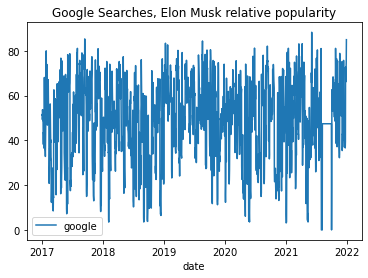

In [627]:
sns.lineplot(data=my_google_df)
plt.title('Google Searches, Elon Musk relative popularity')

In [628]:
my_google_df.head()

,google
date,
2017-01-01,49.583333
2017-01-02,51.625000
2017-01-03,51.083333
2017-01-04,53.708333
2017-01-05,52.791667


In [629]:
my_google_df.shape

(1826, 1)

In [631]:
my_google_df.isnull().sum()

google    0
dtype: int64

## Crypto Index Data

https://www.spglobal.com/spdji/en/indices/digital-assets/sp-cryptocurrency-bdm-ex-largecap-index/

M-F data 

In [680]:
url = 'https://raw.githubusercontent.com/rae-fahrenholtz/Elon/main/data/cyrtoSandP.csv'

In [681]:
#includes extra unnecessary unnamed columns 
df_raw = pd.read_csv(url, index_col='date')

In [682]:
df_raw.head()

,price,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
date,,,,,,
2/28/17,100.00,NaN,NaN,NaN,NaN,NaN
3/1/17,105.04,NaN,NaN,NaN,NaN,NaN
3/2/17,120.77,NaN,NaN,NaN,NaN,NaN
3/3/17,122.89,NaN,NaN,NaN,NaN,NaN
3/6/17,123.24,NaN,NaN,NaN,NaN,NaN


In [683]:
my_crypto_df = df_raw[['price']].copy()

In [684]:
my_crypto_df.isnull().sum()

price    0
dtype: int64

In [685]:
my_crypto_df.index = pd.to_datetime(my_crypto_df.index)

In [686]:
my_crypto_df = my_crypto_df.rename(columns={'price': 'crypto'})

In [687]:
my_crypto_df.head()

,crypto
date,
2017-02-28,100.00
2017-03-01,105.04
2017-03-02,120.77
2017-03-03,122.89
2017-03-06,123.24


In [688]:
my_crypto_df.isnull().sum()

crypto    0
dtype: int64

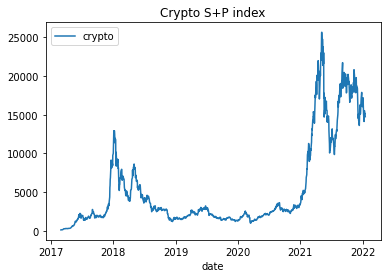

In [689]:
sns.lineplot(data=my_crypto_df)
plt.title('Crypto S+P index')
plt.show()

In [690]:
print("The first day of crypto index data is {}.".format(my_crypto_df.index[0]))

The first day of crypto index data is 2017-02-28 00:00:00.


In [691]:
my_crypto_df.tail()

,crypto
date,
2022-01-11,14712.18
2022-01-12,15523.66
2022-01-13,15085.62
2022-01-14,15197.17
2022-01-17,14740.12


In [692]:
#reindex for all dates, same format as other df
all_dates = pd.date_range(start='2/28/2017', end='12/31/2021')

In [693]:
#for days with no quotes, fill with missing value, (np.NaN is default)
my_crypto_df = my_crypto_df.reindex(all_dates)

In [694]:
my_crypto_df['crypto'] = my_crypto_df['crypto'].fillna(my_crypto_df['crypto'].interpolate())

In [695]:
my_crypto_df.isnull().sum()

crypto    0
dtype: int64

In [696]:
my_crypto_df.head()

,crypto
2017-02-28,100.000000
2017-03-01,105.040000
2017-03-02,120.770000
2017-03-03,122.890000
2017-03-04,123.006667


In [697]:
#reindex for all dates, same format as other df
all_dates = pd.date_range(start='1/01/2017', end='12/31/2021')

In [699]:
#for days with no quotes, fill with missing value, (np.NaN is default)
my_crypto_df = my_crypto_df.reindex(all_dates)

In [700]:
my_crypto_df.shape

(1826, 1)

In [703]:
my_crypto_df.head()

,crypto
2017-01-01,NaN
2017-01-02,NaN
2017-01-03,NaN
2017-01-04,NaN
2017-01-05,NaN


In [702]:
my_crypto_df.tail()

,crypto
2021-12-27,17881.26
2021-12-28,16521.84
2021-12-29,16307.91
2021-12-30,16393.37
2021-12-31,16032.61


## Wikipedia Data

In [176]:
import urllib
import requests
import json

In [177]:
url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Elon_Musk/daily/2016010100/2022010100'

In [178]:
uh = urllib.request.urlopen(url)
data = uh.read()
#print ('Retrieved',len(data),'characters')
js = json.loads(data.decode("utf-8"))

In [179]:
js.items()

dict_items([('items', [{'project': 'en.wikipedia', 'article': 'Elon_Musk', 'granularity': 'daily', 'timestamp': '2016010100', 'access': 'all-access', 'agent': 'all-agents', 'views': 18172}, {'project': 'en.wikipedia', 'article': 'Elon_Musk', 'granularity': 'daily', 'timestamp': '2016010200', 'access': 'all-access', 'agent': 'all-agents', 'views': 18444}, {'project': 'en.wikipedia', 'article': 'Elon_Musk', 'granularity': 'daily', 'timestamp': '2016010300', 'access': 'all-access', 'agent': 'all-agents', 'views': 19158}, {'project': 'en.wikipedia', 'article': 'Elon_Musk', 'granularity': 'daily', 'timestamp': '2016010400', 'access': 'all-access', 'agent': 'all-agents', 'views': 21101}, {'project': 'en.wikipedia', 'article': 'Elon_Musk', 'granularity': 'daily', 'timestamp': '2016010500', 'access': 'all-access', 'agent': 'all-agents', 'views': 19170}, {'project': 'en.wikipedia', 'article': 'Elon_Musk', 'granularity': 'daily', 'timestamp': '2016010600', 'access': 'all-access', 'agent': 'all-a

In [180]:
wiki_df = pd.json_normalize(js, record_path=['items'])

In [181]:
wiki_df.keys()

Index(['project', 'article', 'granularity', 'timestamp', 'access', 'agent',
       'views'],
      dtype='object')

In [182]:
my_wiki_df = pd.DataFrame(wiki_df[['views']])

In [183]:
#removes trailing zeros on timestamp, and pandas format date index
my_wiki_df.index = pd.to_datetime(
    wiki_df['timestamp'].astype(str).str[:-2].astype(np.int64), format='%Y%m%d')

In [184]:
my_wiki_df = my_wiki_df['01-01-2017':'12-31-2021']

In [191]:
my_wiki_df = my_wiki_df.rename(columns={'views':'wiki'})

In [195]:
my_wiki_df.index = my_wiki_df.index.rename('date')

In [196]:
my_wiki_df.head()

,wiki
date,
2017-01-01,19253
2017-01-02,26130
2017-01-03,24114
2017-01-04,24535
2017-01-05,23229


In [197]:
my_wiki_df.shape

(1826, 1)

## Getting all data together

```
my_tweets_df: daily, 0 for days no tweets
my_tsla_df: weekdays, interpolate for weekend data
my_doge_df: start date: 2020-07-30, daily
my_sp_df: weekdays, interpolate for weekend data
my_google_df:
my_crypto_df: start date: 2017-02-28


```

In [704]:
my_elon_df = pd.concat(
    [my_tweets_df, my_tsla_df, my_doge_df, 
     my_sp_df, my_google_df, my_crypto_df, my_wiki_df], axis=1)

In [705]:
#2020-07-30 first day of doge
#2021-12-11 last day of doge

#2017-02-28 first day of crypto index

my_sm_elon_df = my_elon_df['07/30/2020':'12/11/2021']

In [709]:
my_sm_elon_df.tail()

,nlikes,tsla,doge,sp500,google,crypto,wiki
2021-12-07,0.0,1051.750000,0.1764,4686.75,37.708333,14827.370000,60495
2021-12-08,213631.8,1068.960000,0.1790,4701.21,42.958333,15082.850000,67139
2021-12-09,0.0,1003.800000,0.1691,4667.45,42.250000,14241.090000,61292
2021-12-10,280599.6,1017.030000,0.1642,4712.02,42.666667,14218.070000,57992
2021-12-11,127502.0,1000.156667,0.1690,4697.67,40.416667,14013.093333,51157


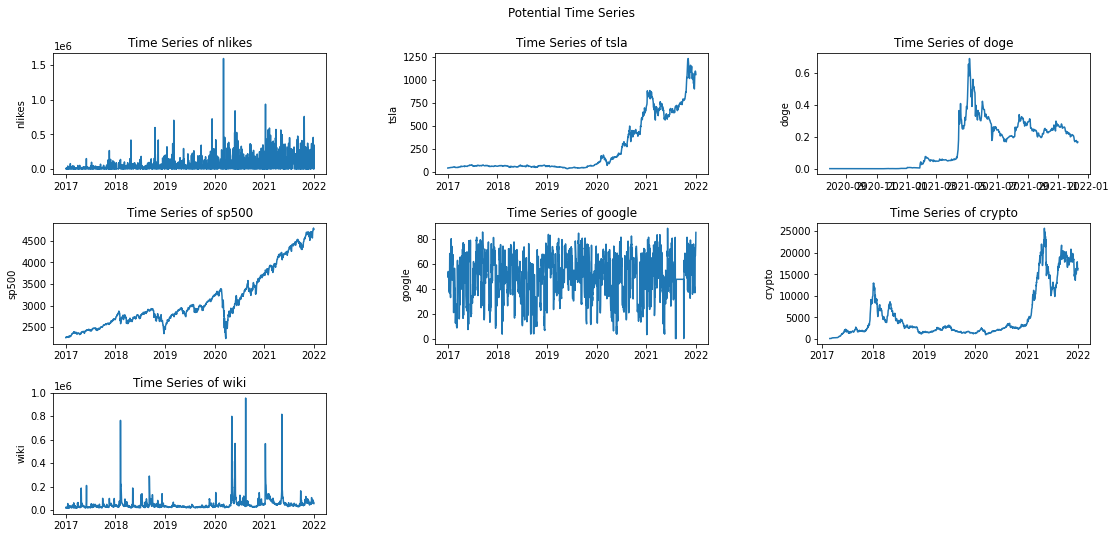

In [633]:
plt.figure(figsize = (18,8))
plt.suptitle('Potential Time Series')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

for i, col in enumerate(my_elon_df.columns):
  plt.subplot(3, 3, i+1)
  sns.lineplot(data=my_elon_df, x=my_elon_df.index, y=col)
  plt.title("Time Series of {}".format(col))
#plt.savefig('')
#files.download('') 
plt.show()

# Let's play

## Number of tweets per day
`my_ntweets_df`: number of elon tweets per day \\
`tweets_df` and `api_tweets` used to create `my_ntweets_df`

###Kaggle Twitter data

In [268]:
#number of tweets per day, series
ntweet_kaggle_s = tweet_df['tweet'].groupby(tweet_df.index.date).count()

In [269]:
ntweets_kaggle_df = pd.DataFrame(ntweet_kaggle_s)
ntweets_kaggle_df = ntweets_kaggle_df.rename(columns={'tweet':'ntweets'})

In [270]:
ntweets_kaggle_df.head()

,ntweets
2017-01-05,1
2017-01-08,2
2017-01-11,1
2017-01-12,1
2017-01-14,2


In [271]:
#reindex for 2017-01-05 : 2021-03-20
all_dates = pd.date_range(start='1/1/2017', end='03/20/2021')

In [272]:
#for days with no tweets, fill with zero
ntweets_kaggle_df = ntweets_kaggle_df.reindex(all_dates, fill_value=0)

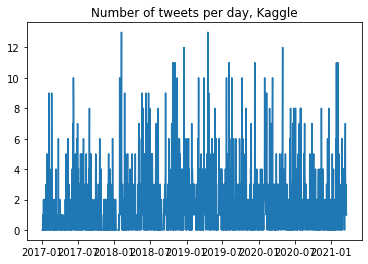

In [273]:
plt.plot(ntweets_kaggle_df)
plt.title('Number of tweets per day, Kaggle')
plt.show()

### API Twitter Data

In [274]:
api_tweets_small_df = api_tweets_df['03/21/21':'12/31/21']

In [275]:
ntweets_api_df = api_tweets_small_df.groupby(api_tweets_small_df.index.date).count()
ntweets_api_df = ntweets_api_df.rename(columns={'nlikes':'ntweets'})

In [276]:
#reindex for 2017-01-05 : 2021-03-20
all_dates = pd.date_range(start='3/21/21', end='12/31/2021')

In [277]:
#for days with no tweets, fill with zero
ntweets_api_df = ntweets_api_df.reindex(all_dates, fill_value=0)


In [278]:
ntweets_api_df.head()

,ntweets
2021-03-21,0
2021-03-22,0
2021-03-23,1
2021-03-24,3
2021-03-25,3


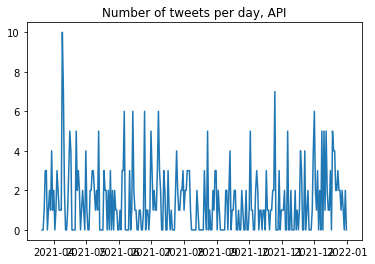

In [279]:
plt.plot(ntweets_api_df)
plt.title('Number of tweets per day, API')
plt.show()

### Kaggle and API together

In [280]:
my_ntweets_df = pd.concat([ntweets_kaggle_df, ntweets_api_df], axis = 0)

### Add to `ntweets` column to `elon_df`

In [282]:
my_elon_df = pd.concat([my_elon_df, my_ntweets_df], axis=1)

### Plots, `ntweets`

In [246]:
#average daily number of likes 
weekly_ntweets = my_ntweets_df.resample('W').mean()
monthly_ntweets = my_ntweets_df.resample('M').mean()
yearly_ntweets = my_ntweets_df.resample('Y').mean()

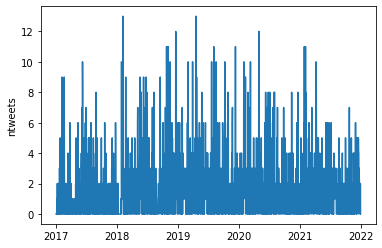

In [247]:
sns.lineplot(y=my_ntweets_df['ntweets'], x=my_ntweets_df.index)
plt.show()

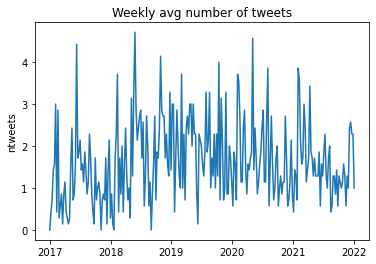

In [248]:
sns.lineplot(y=weekly_ntweets['ntweets'], x=weekly_ntweets.index)
plt.title('Weekly avg number of tweets')
plt.show()

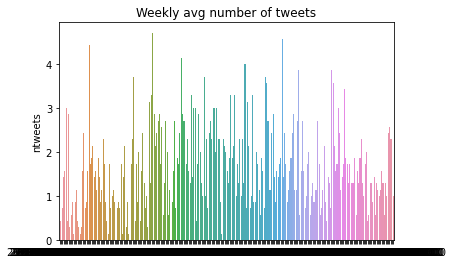

In [256]:
sns.barplot(y=weekly_ntweets['ntweets'], x=weekly_ntweets.index)
plt.title('Weekly avg number of tweets')
plt.show()

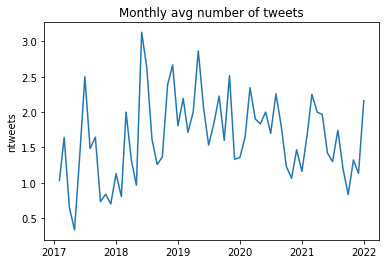

In [249]:
sns.lineplot(y=monthly_ntweets['ntweets'], x=monthly_ntweets.index)
plt.title('Monthly avg number of tweets')
plt.show()

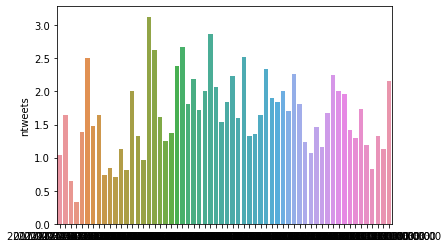

In [255]:
sns.barplot(y=monthly_ntweets['ntweets'], x=monthly_ntweets.index)

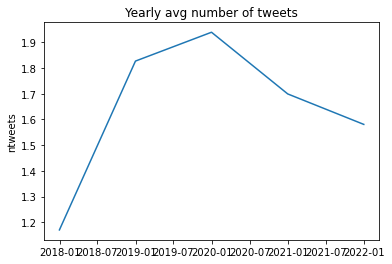

In [250]:
sns.lineplot(y=yearly_ntweets['ntweets'], x=yearly_ntweets.index)
plt.title('Yearly avg number of tweets')
plt.show()

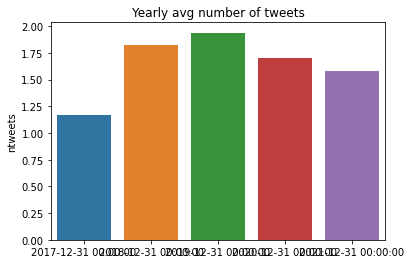

In [257]:
sns.barplot(y=yearly_ntweets['ntweets'], x=yearly_ntweets.index)
plt.title('Yearly avg number of tweets')
plt.show()

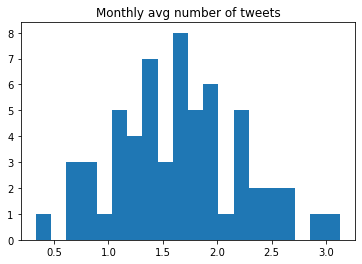

In [251]:
plt.hist(monthly_ntweets['ntweets'], bins=20)
plt.title('Monthly avg number of tweets')
plt.show()

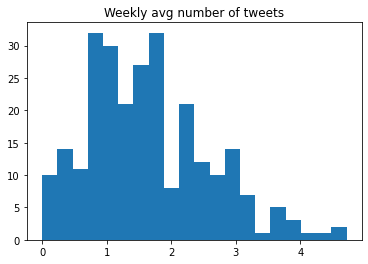

In [252]:
plt.hist(weekly_ntweets['ntweets'], bins=20)
plt.title('Weekly avg number of tweets')
plt.show()

## explore correlation

In [264]:
abs(my_elon_df.corr())

,nlikes,tsla,doge,sp500,google,crypto,ntweets
nlikes,1.000000,0.301600,0.094775,0.292734,0.027915,0.158392,0.005850
tsla,0.301600,1.000000,0.404073,0.927764,0.053288,0.777345,0.023785
doge,0.094775,0.404073,1.000000,0.766234,0.077772,0.847519,0.048007
sp500,0.292734,0.927764,0.766234,1.000000,0.043745,0.810744,0.004070
google,0.027915,0.053288,0.077772,0.043745,1.000000,0.046594,0.055477
crypto,0.158392,0.777345,0.847519,0.810744,0.046594,1.000000,0.044876
ntweets,0.005850,0.023785,0.048007,0.004070,0.055477,0.044876,1.000000


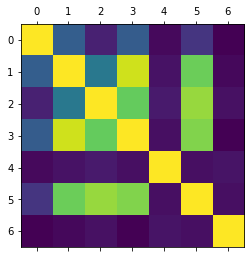

In [261]:
plt.matshow(abs(my_elon_df.corr()))
plt.show()

# Explore Feature Selection
- sklearn.feature_selection.mutual_info_regression

In [317]:
from sklearn.feature_selection import mutual_info_regression

### mutual information calculations

In [746]:
my_elon_df.columns

Index(['nlikes', 'tsla', 'doge', 'sp500', 'google', 'crypto', 'wiki'], dtype='object')

In [721]:
array_tsla = np.array(my_sm_elon_df['tsla']).reshape(-1,1)
array_sp500 = np.array(my_sm_elon_df['sp500']).reshape(-1,1)
array_google = np.array(my_sm_elon_df['google']).reshape(-1,1)
array_wiki = np.array(my_sm_elon_df['wiki']).reshape(-1,1)
array_crypto = np.array(my_sm_elon_df['crypto']).reshape(-1,1)
array_doge = np.array(my_sm_elon_df['doge']).reshape(-1,1)
array_tweets = np.array(my_sm_elon_df['nlikes']).reshape(-1,1)

#### tsla

In [724]:
mutual_info_regression(array_doge, my_sm_elon_df['tsla'])

array([1.01642741])

In [712]:
mutual_info_regression(array_sp500, my_sm_elon_df['tsla'])

array([1.55399861])

In [713]:
mutual_info_regression(array_google, my_sm_elon_df['tsla'])

array([0.32035595])

In [718]:
mutual_info_regression(array_wiki, my_sm_elon_df['tsla'])

array([0.11245836])

In [719]:
mutual_info_regression(array_crypto, my_sm_elon_df['tsla'])

array([1.15331202])

In [720]:
mutual_info_regression(array_doge, my_sm_elon_df['tsla'])

array([1.01653626])

#### DOGE

In [741]:
mutual_info_regression(array_tweets, my_sm_elon_df['doge'])

array([0.06260331])

In [742]:
mutual_info_regression(array_wiki, my_sm_elon_df['doge'])

array([0.16522626])

In [743]:
mutual_info_regression(array_google, my_sm_elon_df['doge'])

array([0.29153936])

In [744]:
mutual_info_regression(array_sp500, my_sm_elon_df['doge'])

array([1.43583179])

In [729]:
mutual_info_regression(array_crypto, my_sm_elon_df['doge'])

array([1.36268023])

#### Tweets

In [730]:
mutual_info_regression(array_wiki, my_sm_elon_df['nlikes'])

array([0.04445351])

In [731]:
mutual_info_regression(array_google, my_sm_elon_df['nlikes'])

array([0])

In [732]:
mutual_info_regression(array_sp500, my_sm_elon_df['nlikes'])

array([0.05486882])

In [733]:
mutual_info_regression(array_crypto, my_sm_elon_df['nlikes'])

array([0.02656281])

#### wiki

In [735]:
mutual_info_regression(array_google, my_sm_elon_df['wiki'])

array([0.12020936])

In [736]:
mutual_info_regression(array_sp500, my_sm_elon_df['wiki'])

array([0.60413642])

In [737]:
mutual_info_regression(array_crypto, my_sm_elon_df['wiki'])

array([0.47376799])

#### google

In [738]:
mutual_info_regression(array_sp500, my_sm_elon_df['google'])

array([0.42489066])

In [739]:
mutual_info_regression(array_crypto, my_sm_elon_df['google'])

array([0.28966803])

####sp500

In [740]:
mutual_info_regression(array_crypto, my_sm_elon_df['sp500'])

array([1.51762352])

### end result: mutual information

link to a handwritten table of mutual information  <br>
[Mutual Information Table](https://drive.google.com/uc?id=1SFoeXmpPf05AI_1L4IzrsPV__5sTFYt4)